In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_curve, average_precision_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir = '/content/drive/My Drive/images'

In [4]:
batch_size = 32
img_size = (224, 224)


In [5]:
# === Step 1: Collect image paths and labels ===
classes = ["0", "1"]
data = []

for label, class_name in enumerate(classes):
    folder = os.path.join(data_dir, class_name)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            data.append((os.path.join(folder, fname), label))

df = pd.DataFrame(data, columns=["filepath", "label"])
print("Total samples:", len(df))
print(df["label"].value_counts())

Total samples: 17796
label
0    16934
1      862
Name: count, dtype: int64


In [6]:
# === Step 2: Stratified Split ===
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

print("\nTrain class distribution:\n", train_df["label"].value_counts())
print("\nVal class distribution:\n", val_df["label"].value_counts())

# === Step 3: Function to load and preprocess images ===
def load_and_preprocess_image(path, label, img_size=(224, 224)):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.ensure_shape(img, [None, None, 3])   # make sure TensorFlow knows it’s an image
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label






Train class distribution:
 label
0    13546
1      690
Name: count, dtype: int64

Val class distribution:
 label
0    3388
1     172
Name: count, dtype: int64


In [ ]:
# @title
import os
print(all(os.path.exists(p) for p in train_df["filepath"]))

True


In [7]:
# === Step 4: Create TensorFlow Datasets ===
train_ds = tf.data.Dataset.from_tensor_slices((train_df["filepath"].values, train_df["label"].values))
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df["filepath"].values, val_df["label"].values))
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
# === Step 5: Compute Class Weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df["label"]),
    y=df["label"]
)
class_weights = dict(enumerate(class_weights))
print("\nClass weights:", class_weights)



Class weights: {0: np.float64(0.525451753867958), 1: np.float64(10.322505800464038)}


In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

In [11]:
model.load_weights("/content/drive/MyDrive/image_model_weights.weights.h5")

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
    class_weight=class_weights
)


Epoch 1/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 3209s 7s/step - accuracy: 0.5299 - loss: 0.7241 - val_accuracy: 0.8921 - val_loss: 0.6118
Epoch 2/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.5265 - loss: 0.6967 - val_accuracy: 0.8699 - val_loss: 0.6007
Epoch 3/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 507s 1s/step - accuracy: 0.5553 - loss: 0.6772 - val_accuracy: 0.8666 - val_loss: 0.5780
Epoch 4/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 453s 963ms/step - accuracy: 0.6369 - loss: 0.6539 - val_accuracy: 0.9174 - val_loss: 0.4847
Epoch 5/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 505s 1s/step - accuracy: 0.6514 - loss: 0.6541 - val_accuracy: 0.9045 - val_loss: 0.4914
Epoch 6/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.6506 - loss: 0.6473 - val_accuracy: 0.9006 - val_loss: 0.4850
Epoch 7/10
445/445 ━━━━━━━━━━━━━━━━━━━━ 506s 1s/step - accuracy: 0.6746 - loss: 0.6268 - val_accuracy: 0.7045 - val_loss: 0.6008


In [ ]:
loss, acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {acc*100:.2f}%")

112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 773ms/step - accuracy: 0.9160 - loss: 0.4843
Validation Accuracy: 91.74%


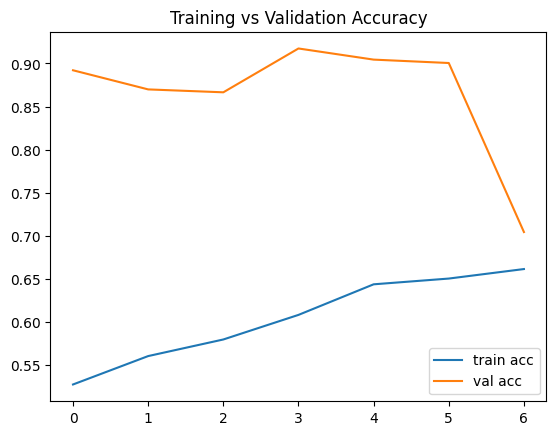

In [ ]:
# STEP 10: Plot training history
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

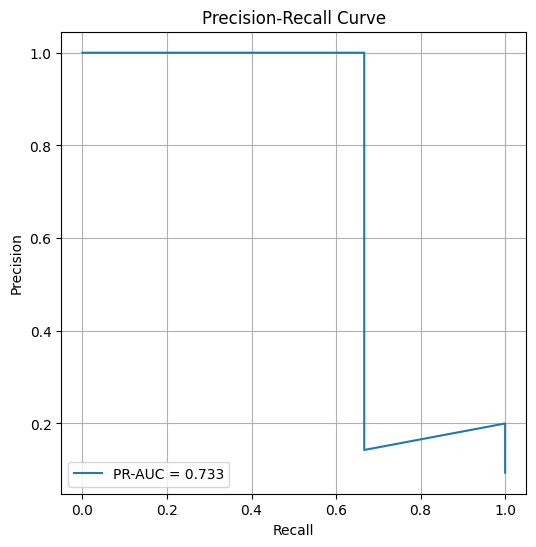

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get one batch from val_ds
val_images, val_labels = next(iter(val_ds))

# Get predictions
y_pred = model.predict(val_images, verbose=0).ravel()
y_true = val_labels.numpy().astype(int).ravel()

# Compute precision-recall and PR-AUC
precision, recall, thresholds = precision_recall_curve(y_true, y_pred, pos_label=1)
pr_auc = average_precision_score(y_true, y_pred)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label=f'PR-AUC = {pr_auc:.3f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


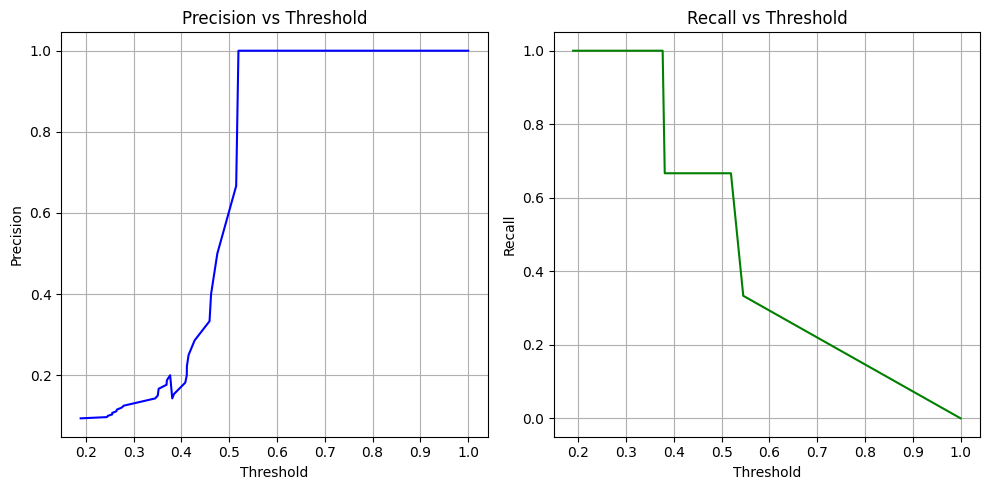

In [26]:
precision, recall, thresholds = precision_recall_curve(y_true, y_pred, pos_label=1)
pr_auc = average_precision_score(y_true, y_pred)
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(10, 5))

# Precision plot
plt.subplot(1, 2, 1)
plt.plot(thresholds, precision, color='blue')
plt.title('Precision vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.grid(True)

# Recall plot
plt.subplot(1, 2, 2)
plt.plot(thresholds, recall, color='green')
plt.title('Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
model.save_weights("/content/drive/MyDrive/image_model_weights.weights.h5")

